<a href="https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language?scriptVersionId=140900240" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This notebook is created for [Kaggle's Sign Language Classifier Competition](https://www.kaggle.com/competitions/asl-signs/code)

In this notebook, I used notebooks from various sources and modify them to get this notebook. Please give upvotes to them if you also find it useful:

- I used some of the data visualization of the landmark from [Sign Language EDA & Visualization](https://www.kaggle.com/code/mayukh18/sign-language-eda-visualization).

- I used the preprocessed tensorflow Dataset from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).

- I train my model following the notebook. [Submission for variable length time-series model](https://www.kaggle.com/code/aapokossi/submission-for-variable-length-time-series-model). I then tweak the layers and the epoch to increase the accuracy.

I also included comments and links to help study the model further.

<a id="contents"></a>
# Contents
1. [Import Libraries and Set File Directories](#section-one)
2. [Visualize data](#section-two)
3. [Load Data](#section-three)
4. [Train Model](#section-four)
5. [Submit Model](#section-five)

<a id="section-one"></a>
# Import Libraries and Set File Directories

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers

In [2]:
# set files directories
LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"

<a id="section-two"></a>
# Visualize data

Slightly different from a dataframe, in this competition we will be using a [parquet](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705). We will read it using the command `read_parquet`.

In [3]:
# read the data, the type of the data
sample = pd.read_parquet("/kaggle/input/asl-signs/train_landmark_files/16069/100015657.parquet")
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013


Everyone likes to visualize things right? Since the data is about sequences of hand movement, we might not be able to see it from tabular data only. Let us instead plot the movement into matplotlib.

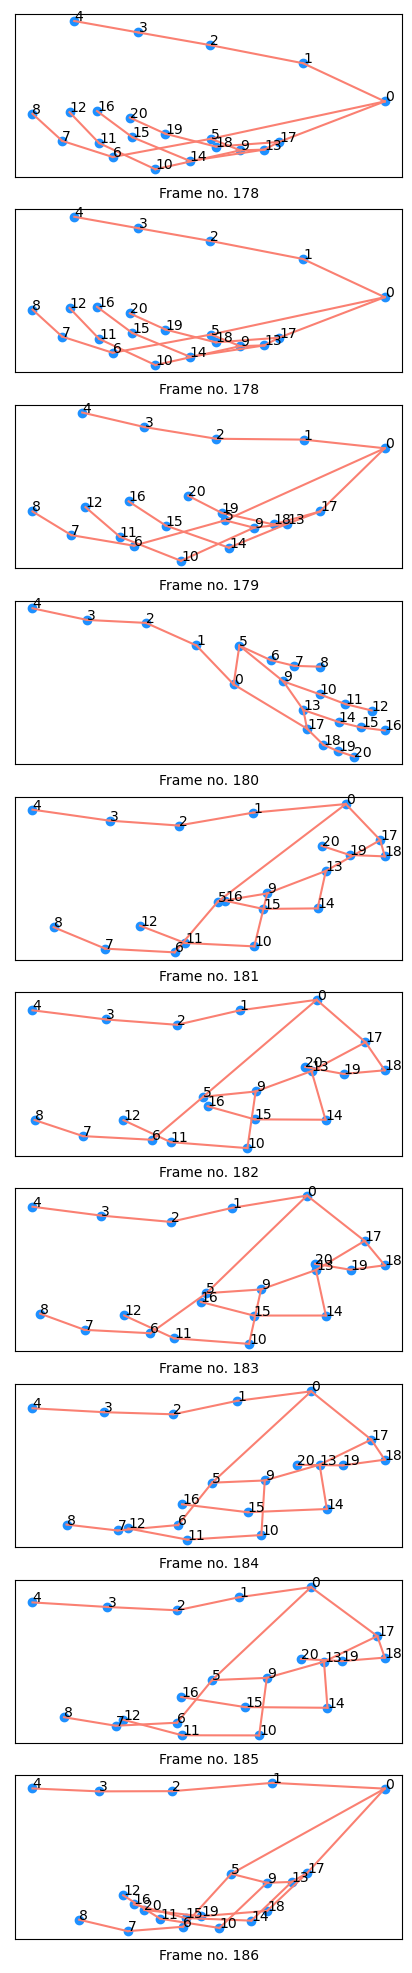

In [4]:
# pick the left hand and right hand points
sample_left_hand = sample[sample.type == "left_hand"]
sample_right_hand = sample[sample.type == "right_hand"]

# edges that represents the hand edges
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

# plotting a single frame into matplotlib
def plot_frame(df, frame_id, ax):
    df = df[df.frame == frame_id].sort_values(['landmark_index'])
    x = list(df.x)
    y = list(df.y)
    
    # plotting the points
    ax.scatter(df.x, df.y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))
    
    # plotting the edges that represents the hand
    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
        ax.set_xlabel(f"Frame no. {frame_id}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# plotting the multiple frames
def plot_frame_seq(df, frame_range, n_frames):
    frames = np.linspace(frame_range[0],frame_range[1],n_frames, dtype = int, endpoint=True)
    fig, ax = plt.subplots(n_frames, 1, figsize=(5,25))
    for i in range(n_frames):
        plot_frame(df, frames[i], ax[i])
        
    plt.show()

plot_frame_seq(sample_left_hand, (178,186), 10)

<a id="section-three"></a>
# Load Data

In [5]:
# Set constants and pick important landmarks
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))
DATA_PATH = "/kaggle/input/saved-tfdataset-of-google-isl-recognition-data/GoogleISLDatasetBatched"
DS_CARDINALITY = 185
VAL_SIZE  = 18
N_SIGNS = 250
ROWS_PER_FRAME = 543

To keep it simple, we will use the preprocessed [tf.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).

In [6]:
def preprocess(ragged_batch, labels):
    ragged_batch = tf.gather(ragged_batch, LANDMARK_IDX, axis=2)
    ragged_batch = tf.where(tf.math.is_nan(ragged_batch), tf.zeros_like(ragged_batch), ragged_batch)
    return tf.concat([ragged_batch[...,i] for i in range(3)],-1), labels

dataset = tf.data.Dataset.load(DATA_PATH)
dataset = dataset.map(preprocess)
val_ds = dataset.take(VAL_SIZE).cache().prefetch(tf.data.AUTOTUNE)
train_ds = dataset.skip(VAL_SIZE).cache().shuffle(20).prefetch(tf.data.AUTOTUNE)

<a id="section-four"></a>
# Train Model

In [7]:
# include early stopping and reducelr
def get_callbacks():
    return [
            tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.5,
            patience = 3
        ),
    ]

# a single dense block followed by a normalization block and relu activation
def dense_block(units, name):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    return lambda x: act(norm(fc(x)))

# the lstm block with the final dense block for the classification
def classifier(lstm_units):
    lstm = layers.LSTM(lstm_units)
    out = layers.Dense(N_SIGNS, activation="softmax")
    drop = layers.Dropout(0.2)
    return lambda x: drop(out(lstm(x)))

Now let us get to the fun part, training the model!

In [8]:
# choose the number of nodes per layer
encoder_units = [512, 256] # tune this
lstm_units = 250 # tune this

#define the inputs (ragged batches of time series of landmark coordinates)
inputs = tf.keras.Input(shape=(None,3*len(LANDMARK_IDX)), ragged=True)

# dense encoder model
x = inputs
for i, n in enumerate(encoder_units):
    x = dense_block(n, f"encoder_{i}")(x)

# classifier model
out = classifier(lstm_units)(x)

model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None, None, 512)         135680    
                                                                 
 layer_normalization (LayerN  (None, None, 512)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                             

In [9]:
# add a decreasing learning rate scheduler to help convergence
steps_per_epoch = DS_CARDINALITY - VAL_SIZE
boundaries = [steps_per_epoch * n for n in [20,40,60]]
values = [1e-3,1e-4,1e-5,1e-6]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = optimizers.Adam(lr_sched)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

In [10]:
# fit the model with 100 epochs iteration
model.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks(),
          epochs = 80)

Epoch 1/80
167/167 [==============================] - 176s 808ms/step - loss: 7.3568 - accuracy: 0.0081 - sparse_top_k_categorical_accuracy: 0.0383 - val_loss: 5.0598 - val_accuracy: 0.0199 - val_sparse_top_k_categorical_accuracy: 0.0951 - lr: 0.0010
Epoch 2/80
167/167 [==============================] - 44s 265ms/step - loss: 6.8037 - accuracy: 0.0500 - sparse_top_k_categorical_accuracy: 0.1641 - val_loss: 4.2598 - val_accuracy: 0.0971 - val_sparse_top_k_categorical_accuracy: 0.2807 - lr: 0.0010
Epoch 3/80
167/167 [==============================] - 44s 264ms/step - loss: 6.2221 - accuracy: 0.1194 - sparse_top_k_categorical_accuracy: 0.3160 - val_loss: 3.8038 - val_accuracy: 0.1541 - val_sparse_top_k_categorical_accuracy: 0.3989 - lr: 0.0010
Epoch 4/80
167/167 [==============================] - 44s 266ms/step - loss: 5.8075 - accuracy: 0.1853 - sparse_top_k_categorical_accuracy: 0.4167 - val_loss: 3.2736 - val_accuracy: 0.2413 - val_sparse_top_k_categorical_accuracy: 0.5344 - lr: 0.0010

<a id="section-five"></a>
# Submit Model

Now it is time to submit. In this competition, we should submit the model itself.

In [11]:
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None, None, 512)         135680    
                                                                 
 layer_normalization (LayerN  (None, None, 512)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                             

In [12]:
def get_inference_model(model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs")
    
    # drop most of the face mesh
    x = tf.gather(inputs, LANDMARK_IDX, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates ()
    x = tf.concat([x[...,i] for i in range(3)], -1)

    x = tf.expand_dims(x,0)
    
    # call trained model
    out = model(x)
    
    # explicitly name the final (identity) layer for the submission format
    out = layers.Activation("linear", name="outputs")(out)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=out)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

In [13]:
inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 88, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]

In [14]:
# save the model
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"

# submit the model
with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path

  adding: model.tflite (deflated 8%)
